In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline
from pandas.plotting import scatter_matrix
import json
from itertools import chain
import multiprocessing
from collections import defaultdict

# Data Cleaning/EDA

First dataframe - each column is an individual user. This is the main dataframe we will work off of.

In [2]:
df_users = pd.read_json('radiate_peeps.json')

In [3]:
df_users.set_index('pk', inplace=True)

In [4]:
df_users.head()

,android_api_level,birthday,country,crush_ratio,gender,has_instagram,ios_system_version,last_location,last_login,matches,peep_bubbles__count,tagline
pk,,,,,,,,,,,,
263742,23.0,1997-09-21,US,0.772937,f,False,10.3.2,"[-117.1880506, 33.7205858]",2017-12-25T21:22:11.543180+00:00,[{u'created_on': u'2018-01-24T09:47:08.339733+...,19,🤷🏼‍♀️
292558,NaN,1993-03-30,US,0.674425,f,False,10.3.1,"[-84.2233889662, 30.5663066025]",2018-01-24T21:23:44.066424+00:00,[{u'created_on': u'2018-01-12T04:58:52.210761+...,61,I have discount tickets for most festivals:\n\...
312457,NaN,1990-09-13,US,0.173913,m,False,10.3.3,"[-88.1918462698, 41.5387220045]",2017-10-06T01:28:30.598312+00:00,[{u'created_on': u'2017-09-22T01:11:16.860239+...,4,
238027,NaN,1988-05-18,None,0.183333,m,False,None,"[-122.661078544, 45.5122568272]",2016-07-20T23:57:13.011737+00:00,[{u'created_on': u'2017-05-16T15:52:53.757064+...,3,"Tune in to my radio show ""Learning to Grow"" wi..."
326086,NaN,1997-03-02,None,0.750000,f,False,10.3.3,None,2017-08-25T16:06:45.288857+00:00,[{u'created_on': u'2017-08-25T16:03:49.042583+...,3,


In [5]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 143302 entries, 263742 to 306280
Data columns (total 12 columns):
android_api_level      22972 non-null float64
birthday               143302 non-null object
country                100464 non-null object
crush_ratio            143302 non-null float64
gender                 143302 non-null object
has_instagram          143302 non-null bool
ios_system_version     88708 non-null object
last_location          121891 non-null object
last_login             143302 non-null object
matches                143302 non-null object
peep_bubbles__count    143302 non-null int64
tagline                143302 non-null object
dtypes: bool(1), float64(2), int64(1), object(8)
memory usage: 13.3+ MB


In [6]:
df_users['last_login'] = pd.to_datetime(df_users['last_login'])

In [7]:
df_users['birthday'].replace('1349-12-17', np.nan, inplace=True)
df_users['birthday'] = pd.to_datetime(df_users['birthday'])

In [8]:
# Feature Engineering - age

def calculate_age(bday):
    today = dt.date.today()
    age = today - bday.date()
    return age.days/365.

df_users['age'] = df_users['birthday'].apply(calculate_age)
df_users.dropna(subset=['age'], inplace=True)

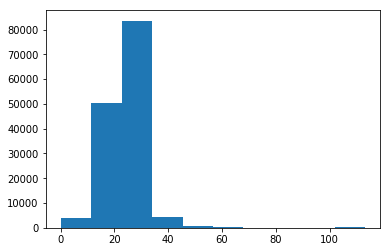

In [9]:
plt.hist(df_users['age'])
plt.show()

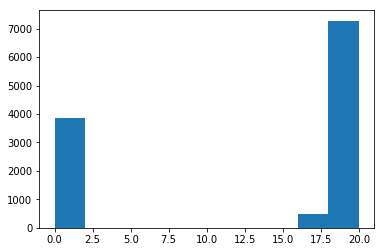

In [11]:
plt.hist(df_users['age'], range=(0,20))
plt.show()

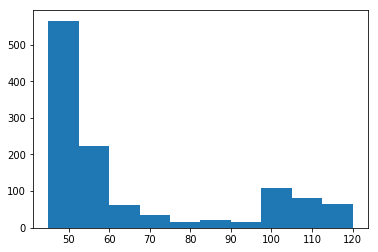

In [12]:
plt.hist(df_users['age'], range=(45,120))
plt.show()

The two histograms above show user spikes at age <2 and >90 which is likely erroneous, so we will remove these observations from the dataset.

In [13]:
df_users = df_users[(df_users['age']>1) & (df_users['age']<90)]

In [14]:
# Convert binary columns to 0's and 1's

df_users['gender'] = df_users['gender'].replace({'m':0,'f':1}) #0 means male
df_users['has_instagram'] = df_users['has_instagram'].map({True:1, False:0})
df_users['iphone_user'] = pd.isnull(df_users['android_api_level']).map({True: 1, False: 0})

df_users.drop(['ios_system_version','android_api_level'], axis=1, inplace=True)

In [15]:
# Feature enginnering - has bio

df_users['has_bio'] = df_users['tagline'].apply(lambda x: 0 if x=='' else 1)

In [16]:
# need to remove all matches with "Rad the Rhino", a robot who is matched with all users 

def remove_rad_match(row):
    return row[1:]

df_users['matches'] = df_users['matches'].apply(remove_rad_match)

In [17]:
# Feature engineering - create avg num messages column

def avg_num_msgs(row):
    sum_msgs = 0
    for d in row:
        sum_msgs += d['num_privatemessages']
        
    total_matches = len(row)
    if total_matches==0:
        return 0
    else:
        return sum_msgs/total_matches
    
df_users['avg_num_msgs'] = df_users['matches'].apply(avg_num_msgs)

In [18]:
# Feature engineering - number of matches per user

df_users['num_matches'] = df_users['matches'].apply(lambda x: len(x))
df_users['num_matches'].fillna(0, inplace=True)

df_users.drop('matches', axis=1, inplace=True)

# Logins

In [19]:
df_logins = pd.read_csv('radiate_logins.csv', usecols=[1,2], parse_dates=['login'])

In [21]:
df_logins.head()

,pk,login
0,263742,2017-12-25 21:22:11.523082
1,263742,2017-12-25 21:10:39.479529
2,263742,2017-12-25 04:02:56.129357
3,263742,2017-12-25 04:02:23.743966
4,263742,2017-12-25 03:58:38.612911


In [22]:
df_logins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34549450 entries, 0 to 34549449
Data columns (total 2 columns):
pk       int64
login    datetime64[ns]
dtypes: datetime64[ns](1), int64(1)
memory usage: 527.2 MB


In [23]:
df_logins['weekend'] = np.where(df_logins['login'].dt.weekday>=5, 1, 0) #sat and sun
df_logins['weekday'] = np.where(df_logins['login'].dt.weekday<5, 1, 0)

# 0 is Monday and 6 is Sunday

In [24]:
def calendar_qtr(row):
    doy = row.timetuple().tm_yday
    if doy in range(0, 92):
        return 'Q1'
    elif doy in range(92, 183):
        return 'Q2'
    elif doy in range(183, 274):
        return 'Q3'
    else:
        return 'Q4'

In [25]:
df_logins['qtr'] = df_logins['login'].apply(calendar_qtr)

In [26]:
df_logins['year'] = df_logins['login'].dt.year

In [27]:
# Only look at 2016 and 2017 since these are the only two full calendar years we have

df_logins = df_logins[(df_logins['year']==2016) | (df_logins['year']==2017)]

In [28]:
df_logins['qtr_yr'] = df_logins['qtr'] + '-' + df_logins['year'].map(str)

In [29]:
# Create dummies for qtr_yr

qtr_yr_dum = pd.get_dummies(df_logins['qtr_yr'], prefix='')
df_logins = pd.concat([df_logins, qtr_yr_dum], axis=1)

In [32]:
# df_logins = pd.read_pickle('df_logins.pkl')

In [30]:
# 'groupby' the logins dataframe so we can analyze logins per user

df_logins_by_user = df_logins.groupby('pk').sum()

In [31]:
df_logins_by_user.head()

,weekend,weekday,year,_Q1-2016,_Q1-2017,_Q2-2016,_Q2-2017,_Q3-2016,_Q3-2017,_Q4-2016,_Q4-2017
pk,,,,,,,,,,,
200016,8660,21326,60464982,7603.0,1450.0,4584.0,8386.0,3345.0,1375.0,1248.0,1995.0
200017,10587,32935,87761354,6151.0,5398.0,7090.0,7312.0,5503.0,3821.0,3776.0,4471.0
200019,6,12,36288,9.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0
200020,55,87,286297,65.0,9.0,12.0,1.0,16.0,9.0,24.0,6.0
200029,28,159,377054,43.0,26.0,46.0,28.0,22.0,7.0,14.0,1.0


In [33]:
# Feature engineering - % of logins on weekends and per calendar quarter

df_logins_by_user['total'] = df_logins_by_user['weekend']+df_logins_by_user['weekday']

df_logins_by_user['pct_logins_wknd'] = df_logins_by_user['weekend']/df_logins_by_user['total']

df_logins_by_user['pct_logins_Q1'] = (df_logins_by_user['_Q1-2016']+df_logins_by_user['_Q1-2017'])/df_logins_by_user['total']
df_logins_by_user['pct_logins_Q2'] = (df_logins_by_user['_Q2-2016']+df_logins_by_user['_Q2-2017'])/df_logins_by_user['total']
df_logins_by_user['pct_logins_Q3'] = (df_logins_by_user['_Q3-2016']+df_logins_by_user['_Q3-2017'])/df_logins_by_user['total']
df_logins_by_user['pct_logins_Q4'] = (df_logins_by_user['_Q4-2016']+df_logins_by_user['_Q4-2017'])/df_logins_by_user['total']

Note: I have included all quarters for now to make interpretation easier in EDA but I will drop Q1 later on to make it the baseline before running models

Because music festivals are seasonal (more popular in late Spring, Summer, and early Fall), we want to analyze the data on a year-over-year basis. First, we define quarterly churn for each user. A value of 1 means that this user logged in in a particular calendar quarter last year, but not this year. 

The binary churn metric we will use is, if a user churned in any particular calendar quarter, they are considered a churn user.

In [34]:
def quarterly_churn(row16,row17):
    if int(row16)>0 and int(row17)==0:
        return 1
    else:
        return 0

In [35]:
for q in ['_Q1','_Q2','_Q3','_Q4']:
    col_16 = q+'-2016'
    col_17 = q+'-2017'
    churn = q[1:]+'_churn'
    df_logins_by_user[churn] = df_logins_by_user.apply(lambda x: quarterly_churn(x[col_16], x[col_17]),axis=1)

In [37]:
df_logins_by_user = df_logins_by_user[(df_logins_by_user['_Q1-2016']>0) |
                                      (df_logins_by_user['_Q2-2016']>0) |
                                      (df_logins_by_user['_Q3-2016']>0) |
                                      (df_logins_by_user['_Q4-2016']>0) ]

In [38]:
df_logins_by_user['churn'] = np.where((df_logins_by_user['Q1_churn']>0)|
                                      (df_logins_by_user['Q2_churn']>0)|
                                      (df_logins_by_user['Q3_churn']>0)|
                                      (df_logins_by_user['Q4_churn']>0), 1, 0)

In [39]:
# MERGE churn and login percents on weekend/calendar quarters with users dataframe

df_users = df_users.merge(df_logins_by_user[['pct_logins_wknd','pct_logins_Q1','pct_logins_Q2','pct_logins_Q3','pct_logins_Q4','churn']], left_index=True, right_index=True)

# Events

In [40]:
df_events = pd.read_json('radiate_bubbles.json', convert_dates=['date_start','date_end'])

In [41]:
df_events = df_events.set_index('bubble_id')

In [42]:
df_events.head()

,address,date_end,date_start,display_name
bubble_id,,,,
205,"Todd Mission, TX",2017-05-07,2017-05-05,Middlelands
179,"Nos Events Center, CA",2017-11-25,2017-11-24,Dreamstate
46,"San Bernardino, CA",2017-09-16,2017-09-15,Nocturnal Wonderland
278,"Oklahoma City, OK",2017-08-19,2017-08-19,DayDream
54,"Atlantic City, NJ",2016-08-02,2016-08-01,Electric Adventure


In [43]:
df_events.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 217 entries, 205 to 224
Data columns (total 4 columns):
address         217 non-null object
date_end        217 non-null datetime64[ns]
date_start      217 non-null datetime64[ns]
display_name    217 non-null object
dtypes: datetime64[ns](2), object(2)
memory usage: 8.5+ KB


In [44]:
def get_loc(row):
    ix = row.find(',')
    return row[ix+2:].upper()

df_events['festival_loc'] = df_events['address'].apply(get_loc)

In [45]:
df_events.replace({
    'CALIFORNIA':'CA',
    'OREGON':'OR',
    'MICHIGAN':'MI',
    'WEST VIRGINIA':'WV',
    'OHIO':'OH',
    'ARIZONA':'AZ',
    'VIRGINIA':'VA',
    'TEXAS':'TX',
    'FLORIDA':'FL',
    'CHICAGO, MICHIGAN':'IL', #this is fine because IL and MI are both in East North Central census division
    'DELAWARE':'DE',
    'NITED KINGDOM':'UNITED KINGDOM',
    'UK':'UNITED KINGDOM',
    '.C. / BALTIMORE':'MD',
    'ITI FIELD':'NY',
    'ON':'CANADA'
}, inplace=True)

In [46]:
df_events['festival_loc'].value_counts().head()

CA        38
FL        18
TX        17
NY        16
CANADA    12
Name: festival_loc, dtype: int64

Festival locations are spread across many states and countries so I will group them into census regions and a total Europe to allow for general trend analysis.

In [47]:
census = pd.read_csv('census_divisions.csv')

In [48]:
census.head()

,State,State Code,Region,Division
0,Alaska,AK,West,Pacific
1,Alabama,AL,South,East South Central
2,Arkansas,AR,South,West South Central
3,Arizona,AZ,West,Mountain
4,California,CA,West,Pacific


In [49]:
# MERGE census dataframe with event dataframe

df_events = df_events.merge(census, how ='left', left_on='festival_loc', right_on='State Code')
df_events.drop(['State', 'State Code', 'Region'], axis=1, inplace=True)

In [50]:
df_events.rename(columns={'Division':'Region'}, inplace=True)

In [51]:
# Inspect Non-US festivals

df_events[df_events['Region'].isnull()]['festival_loc'].value_counts()

CANADA            12
UNITED KINGDOM     4
FRANCE             4
BELGIUM            2
GERMANY            2
MEXICO             2
NETHERLANDS        2
HUNGARY            1
CROATIA            1
IRELAND            1
INDIA              1
ICELAND            1
WHENEVER           1
ROMANIA            1
Name: festival_loc, dtype: int64

All non-US events are either in Canada, Mexico, Europe, India, or "Wherever" (Pokemon Go)

In [52]:
df_events.loc[df_events['festival_loc']=='CANADA', 'Region'] = 'Canada'
df_events.loc[df_events['festival_loc']=='MEXICO', 'Region'] = 'Mexico'
df_events.loc[(df_events['festival_loc']=='INDIA')|(df_events['festival_loc']=='WHEREVER'), 'Region'] = 'Misc'
df_events['Region'].fillna('Europe', inplace=True)

In [53]:
region_dum = pd.get_dummies(df_events['Region'], prefix='festival_region')
df_events = pd.concat([df_events, region_dum], axis=1)

In [55]:
# Feature Engineering - avg festival length feature

df_events['festival_length'] = (df_events['date_end'] - df_events['date_start']).dt.days

# Events per User

Each row in this dataframe is for a specific bubble/user combination, so we have bubble and user-specific info

In [56]:
df_user_events = pd.read_csv('radiate_peep_bubbles.csv', usecols=[1,3,4])

In [57]:
df_user_events.head()

,bubble_id,joined_status,pk
0,23,NO,263742
1,293,NO,263742
2,206,NO,263742
3,192,YES,263742
4,211,NO,263742


In [58]:
df_user_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 492185 entries, 0 to 492184
Data columns (total 3 columns):
bubble_id        492185 non-null int64
joined_status    492185 non-null object
pk               492185 non-null int64
dtypes: int64(2), object(1)
memory usage: 11.3+ MB


In [59]:
regions = list(region_dum.columns)

In [60]:
# MERGE festival regions and lengths from df_events with df_user_events

reg_and_len = regions+['festival_length']
df_user_events = df_user_events.merge(df_events[reg_and_len], left_on='bubble_id', right_index=True)

In [61]:
df_user_events_groupby = df_user_events.groupby('pk').sum()

In [62]:
df_user_events_groupby.head()

,bubble_id,festival_region_Canada,festival_region_East North Central,festival_region_East South Central,festival_region_Europe,festival_region_Mexico,festival_region_Middle Atlantic,festival_region_Misc,festival_region_Mountain,festival_region_New England,festival_region_Pacific,festival_region_South Atlantic,festival_region_West North Central,festival_region_West South Central,festival_length
pk,,,,,,,,,,,,,,,
200016,9892,4,7,2,11,0,10,1,11,1,32,21,1,6,195
200017,20884,7,15,2,18,2,21,1,20,4,38,31,3,15,324
200019,1293,0,3,1,1,0,3,0,2,0,5,3,0,1,37
200020,3079,2,3,2,7,1,4,1,4,1,14,9,0,2,97
200029,1295,1,2,0,1,0,1,1,3,0,6,6,0,2,43


In [63]:
df_user_events_groupby['total'] = df_user_events_groupby[regions].sum(axis=1)

In [64]:
# Feature Engineering - % of user's total events per region

region_pct_cols = []

for region in regions:
    col_name = "pct_"+region
    region_pct_cols.append(col_name)
    df_user_events_groupby[col_name] = 1.*df_user_events_groupby[region]/df_user_events_groupby['total']

In [65]:
# Feature Engineering - number of Radiate users attending festivals

joined = df_user_events[(df_user_events['joined_status']=='YES')|(df_user_events['joined_status']=='MAYBE')]
num_users_bubble = (joined.groupby(['bubble_id'])['pk'].count()
                    .to_frame()
                    .rename(columns={'pk':'num_users_attending'}))

In [66]:
num_users_bubble.head()

,num_users_attending
bubble_id,
9,2256
10,1496
11,1930
12,836
18,16114


In [67]:
# MERGE num users attending with df_user_events

df_user_events = df_user_events.merge(num_users_bubble, left_on='bubble_id', right_index=True)

In [68]:
# Convert num users to mean num users at event, per user

avg_num_users = (df_user_events.groupby('pk')['num_users_attending'].mean()
                 .to_frame()
                 .rename(columns={'num_users_attending':'avg_num_users_attending'}))

In [69]:
avg_num_users.head()

,avg_num_users_attending
pk,
200016,2812.669811
200017,2061.657143
200019,3909.526316
200020,3528.460000
200029,4182.391304


In [70]:
# MERGE avg num users with df_user_events_groupby

df_user_events_groupby = df_user_events_groupby.merge(avg_num_users, left_index=True, right_index=True)

In [71]:
# Create dummy variables for join statuses

join_dums = pd.get_dummies(df_user_events['joined_status'], prefix='joined')
df_user_events = pd.concat([df_user_events, join_dums], axis=1).drop('joined_status', axis=1)

In [72]:
df_user_events.head()

,bubble_id,pk,festival_region_Canada,festival_region_East North Central,festival_region_East South Central,festival_region_Europe,festival_region_Mexico,festival_region_Middle Atlantic,festival_region_Misc,festival_region_Mountain,festival_region_New England,festival_region_Pacific,festival_region_South Atlantic,festival_region_West North Central,festival_region_West South Central,festival_length,num_users_attending,joined_MAYBE,joined_NO,joined_YES
0,23,263742,0,0,0,0,0,0,0,0,0,1,0,0,0,0,22691,0,1,0
69,23,292558,0,0,0,0,0,0,0,0,0,1,0,0,0,0,22691,0,0,1
83,23,328806,0,0,0,0,0,0,0,0,0,1,0,0,0,0,22691,0,0,1
103,23,283681,0,0,0,0,0,0,0,0,0,1,0,0,0,0,22691,0,0,1
108,23,339394,0,0,0,0,0,0,0,0,0,1,0,0,0,0,22691,0,0,1


In [73]:
# Feature Engineering - Avg Festival Length

df_fest_len = df_user_events.groupby('pk')['festival_length'].mean().to_frame()
df_fest_len.rename(columns={'festival_length':'avg_festival_length'}, inplace=True)

df_user_events_groupby = df_user_events_groupby.merge(df_fest_len, left_index=True, right_index=True)
# df_user_events.drop('festival_length', axis=1, inplace=True)

In [74]:
# MERGE with user dataframe

df_users = df_users.merge(df_user_events_groupby.loc[:,'pct_festival_region_Canada':],
                          left_index=True, right_index=True)

# More EDA

In [75]:
df_users.head()

,birthday,country,crush_ratio,gender,has_instagram,last_location,last_login,peep_bubbles__count,tagline,age,...,pct_festival_region_Middle Atlantic,pct_festival_region_Misc,pct_festival_region_Mountain,pct_festival_region_New England,pct_festival_region_Pacific,pct_festival_region_South Atlantic,pct_festival_region_West North Central,pct_festival_region_West South Central,avg_num_users_attending,avg_festival_length
pk,,,,,,,,,,,,,,,,,,,,,
263742,1997-09-21,US,0.772937,1,0,"[-117.1880506, 33.7205858]",2017-12-25 21:22:11.543180,19,🤷🏼‍♀️,20.427397,...,0.266667,0.000000,0.266667,0.000000,0.266667,0.066667,0.0,0.000000,5432.533333,1.266667
260988,1986-04-09,US,0.237527,0,0,"[-81.6426328043, 28.8358446732]",2018-01-18 06:07:33.574752,15,,31.887671,...,0.142857,0.000000,0.071429,0.000000,0.285714,0.285714,0.0,0.071429,6061.500000,2.071429
244211,1994-09-27,US,0.794365,1,1,"[-82.4824394, 27.3921412]",2018-01-22 17:09:54.480483,17,🍄🐢,23.413699,...,0.076923,0.000000,0.000000,0.000000,0.307692,0.384615,0.0,0.076923,5643.846154,1.615385
256286,1996-10-23,US,0.321168,0,0,"[-121.074339177, 38.9138414833]",2018-01-14 23:05:18.539342,47,From Sac town! \nAll about the bass😝 \nSc:tguM...,21.339726,...,0.157895,0.026316,0.105263,0.026316,0.157895,0.210526,0.0,0.078947,3358.894737,1.578947
247662,1992-11-23,US,0.230469,0,0,"[-112.013122771, 40.628634714]",2018-01-21 01:08:56.720441,6,,25.257534,...,0.000000,0.000000,0.000000,0.000000,0.200000,0.400000,0.0,0.200000,3231.600000,2.400000


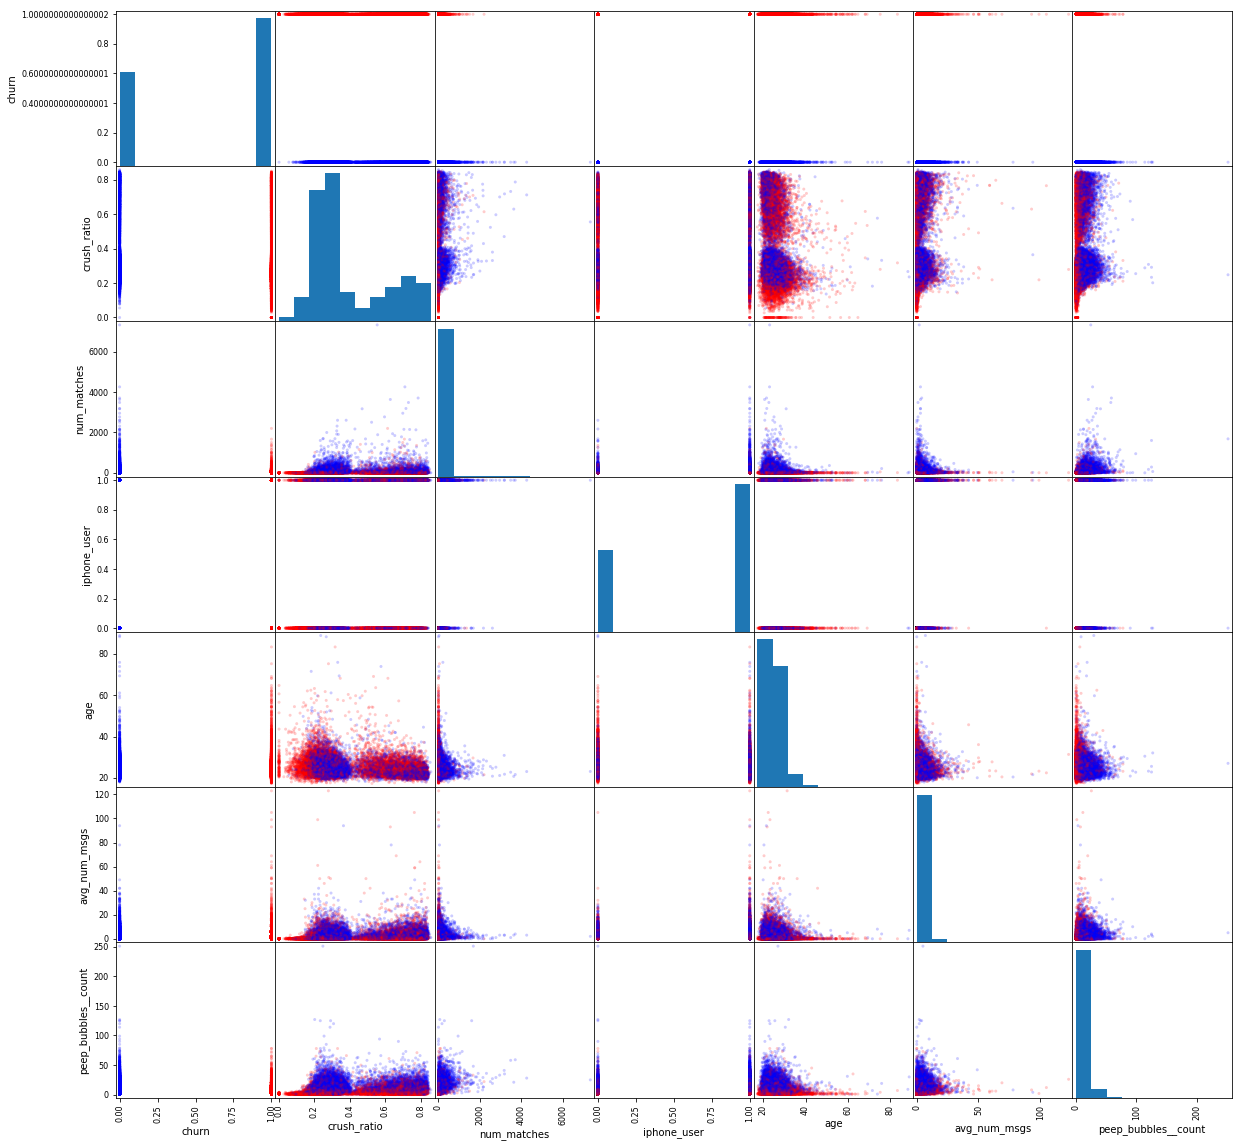

In [155]:
scatter_features = ['churn','crush_ratio', 'num_matches', 'iphone_user', 'age','avg_num_msgs','peep_bubbles__count']
colors = ['red' if i else 'blue' for i in df_users['churn']]
# red means churn

scatter_matrix(df_users[scatter_features], alpha=0.2, figsize=(20, 20), diagonal='hist', color=colors)
plt.show()

Key takeaways:

Histograms:
* 60% churn
* there are two distinct groups within crush ratio - this is because female users tend to have much higher crush ratios than male users
* more iphone users than non-iphone users

Scatters:
* higher num_matches - lower churn
* older users - higher churn
* higher # events - lower churn

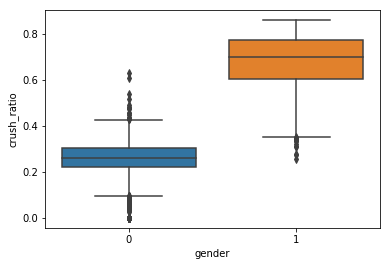

In [158]:
sns.boxplot(x='gender', y='crush_ratio', data=df_users)
plt.show()

In [156]:
df_users.groupby('gender')['crush_ratio'].mean()

gender
0    0.258433
1    0.679459
Name: crush_ratio, dtype: float64

Female users have an average crush ratio of 68% while male users have an average crush ratio of 26%

In [76]:
df_users.describe().T

,count,mean,std,min,25%,50%,75%,max
crush_ratio,24113.0,0.392338,0.212432,0.000000,0.240294,0.300000,0.585714,0.858660
gender,24113.0,0.318044,0.465726,0.000000,0.000000,0.000000,1.000000,1.000000
has_instagram,24113.0,0.126861,0.332824,0.000000,0.000000,0.000000,0.000000,1.000000
peep_bubbles__count,24113.0,9.058724,9.344648,1.000000,3.000000,6.000000,12.000000,251.000000
age,24113.0,25.148669,4.280560,17.293151,22.263014,24.287671,27.076712,88.865753
iphone_user,24113.0,0.642931,0.479145,0.000000,0.000000,1.000000,1.000000,1.000000
has_bio,24113.0,0.556588,0.496798,0.000000,0.000000,1.000000,1.000000,1.000000
avg_num_msgs,24113.0,2.299258,4.209917,0.000000,0.000000,1.000000,3.000000,123.000000
num_matches,24113.0,55.804131,158.391521,0.000000,0.000000,8.000000,48.000000,7331.000000
pct_logins_wknd,24113.0,0.258455,0.189448,0.000000,0.146572,0.230769,0.321254,1.000000


Key stats on the total population:
* 61% churn
* avg crush ratio = 40%
* 30% women
* avg peep bubbles count = 9
* avg age = 25.1
* 65% iphone users
* 56% have bios
* avg num messages = 1.3
* avg num matches = 56

In [126]:
def plot_scatter(x,y):
    plt.scatter(df_users[x], df_users[y])
    plt.xlabel(x)
    plt.ylabel(y)
    plt.show()
    
# DELETE??

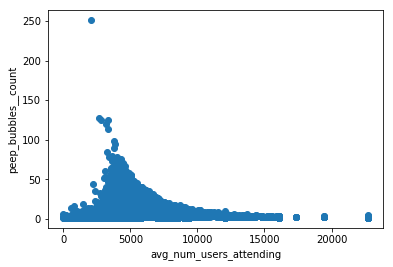

In [127]:
plot_scatter('avg_num_users_attending','peep_bubbles__count')

# Modeling

In [91]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
import sklearn.metrics as skm
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, BaggingClassifier
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [129]:
df_users2 = df_users.rename(columns = {'pct_festival_region_Europe':'% events attended in Europe',
                    'pct_festival_region_West North Central': '% events attended in West North Central',
                    'pct_festival_region_East North Central': '% events attended in East North Central',
                    'pct_logins_Q1': '% logins in Q1',
                    'pct_logins_Q2': '% logins in Q2',
                    'pct_logins_Q3': '% logins in Q3',
                    'pct_logins_Q4': '% logins in Q4',
                    'num_matches': '# matches',
                    'pct_logins_wknd': '% logins on weekend',
                    'peep_bubbles__count': "# events RSVPed",
                    'crush_ratio': "'swipe right' ratio",
                    'iphone_user': 'iphone user',
                    'avg_num_msgs': 'avg # messages',
                    'avg_festival_length': 'avg event length',
                    'has_instagram': 'instagram user',
                    'avg_num_users_attending': 'avg # Radiate users attending',
                    'pct_peeps_left': '% events RSVPed and then cancelled'
                   })

In [131]:
y = df_users2['churn']
X = df_users2.drop(['churn','tagline','birthday', 'last_login',
                    'country', 'last_location', '# matches'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.20, random_state=67)

Dropping columns:
* churn - we should not include this in the model since this is what we are trying to predict!
* last_login - we used this to define churn, so definitely don't want to include
* age - we have age_in_days... we only used age for EDA purposes
* bubble_id - this is just an identifier for the actual festivals and we have coded the attributes of festivals in separate features
* tagline - this is text based and we used it for our topic modeling
* matches - we used this to create num_matches
* num_matches - highly correlated w/ other features

In [119]:
def run_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    print "Accuracy:", round(model.score(X_test, y_test),3)
    print "AUC:", round(skm.roc_auc_score(y_test, model.predict(X_test)),3)
    return

In [120]:
def run_grid_search(clf, grid_params, score_type='roc_auc'):
    grid_cv = GridSearchCV(clf, grid_params, n_jobs=-1, scoring=score_type)
    grid_cv.fit(X_train, y_train)
    print "best parameters: ", grid_cv.best_params_
    print "best score: ", "{0:.3f}".format(grid_cv.best_score_)
    best_model = grid_cv.best_estimator_
    return best_model

# Logistic Regression

In [83]:
logistic = LogisticRegression()

In [84]:
run_model(logistic, X_train, X_test, y_train, y_test)

Accuracy: 0.715
AUC: 0.683


# SVM

In [85]:
svm_pipe = Pipeline([('scaler', StandardScaler()),
                        ('svc', SVC(kernel='rbf'))])
svm_pipe.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svc', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])

In [86]:
run_model(svm_pipe, X_train, X_test, y_train, y_test)

Accuracy: 0.752
AUC: 0.727


# Random Forest

In [95]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [96]:
run_model(rf, X_train, X_test, y_train, y_test)

Accuracy: 0.744
AUC: 0.734


In [99]:
rf_grid = {
    'max_depth': [4, 8, None],
    'n_estimators': [100, 500, 1000],
    'max_features': ['auto', 'sqrt', 'log2', None],
    'oob_score': [True],
    'bootstrap':[True]
}

In [100]:
rf_grid_cv = GridSearchCV(RandomForestClassifier(), rf_grid, n_jobs=-1, scoring='roc_auc')

In [101]:
rf_grid_cv.fit(X.values, y.values)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [100, 500, 1000], 'max_features': ['auto', 'sqrt', 'log2', None], 'oob_score': [True], 'bootstrap': [True], 'max_depth': [4, 8, None]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [102]:
rf_model = rf_grid_cv.best_estimator_

In [103]:
print "best params:", rf_grid_cv.best_params_

best params: {'max_features': 'auto', 'n_estimators': 1000, 'oob_score': True, 'bootstrap': True, 'max_depth': None}


In [104]:
print "best score:", rf_grid_cv.best_score_

best score: 0.8365839715983808


# Boosting

In [105]:
gbc = GradientBoostingClassifier()

In [106]:
run_model(gbc, X_train, X_test, y_train, y_test)

Accuracy: 0.774
AUC: 0.751


In [107]:
for col, feat_imp in sorted(zip(X.columns, gbc.feature_importances_), key = lambda x:x[1], reverse=True):
    print col, round(feat_imp, 3)

pct_logins_Q2 0.158
num_matches 0.108
peep_bubbles__count 0.105
pct_logins_Q4 0.066
pct_logins_Q1 0.063
pct_logins_wknd 0.06
crush_ratio 0.059
pct_logins_Q3 0.052
iphone_user 0.049
has_instagram 0.039
avg_num_msgs 0.039
avg_num_users_attending 0.036
age 0.023
avg_festival_length 0.02
pct_festival_region_East North Central 0.018
pct_festival_region_East South Central 0.015
pct_festival_region_West North Central 0.015
pct_festival_region_Europe 0.012
pct_festival_region_South Atlantic 0.01
pct_festival_region_Mountain 0.009
pct_festival_region_Canada 0.009
pct_festival_region_New England 0.008
pct_festival_region_Middle Atlantic 0.006
pct_festival_region_West South Central 0.006
pct_festival_region_Pacific 0.005
gender 0.005
pct_festival_region_Misc 0.004
has_bio 0.0
pct_festival_region_Mexico 0.0


In [121]:
# first tune with high learning rate for speed purposes
gbc_grid_1 = {
    'learning_rate': [.1],
    'max_depth': [3, 5, 8],
    'min_samples_leaf': [1, 3, 5],
    'n_estimators': [500, 1000],
    'subsample': [0.5, 0.75, 1.0],
    'max_features': ['sqrt', 'log2', None]
}

# use results from first grid search to inform the second, and also tune learning rate here
gbc_grid_2 = {
    'learning_rate': [.005, .01],
    'max_depth': [1, 3, 5],
    'min_samples_leaf': [5, 7],
    'n_estimators': [200, 500, 1000],
    'subsample': [0.75],
    'max_features': [None]
}

In [167]:
gbc = GradientBoostingClassifier()
gbc_grid_cv = run_grid_search(gbc, gbc_grid_2)

best parameters:  {'learning_rate': 0.01, 'min_samples_leaf': 7, 'n_estimators': 1000, 'subsample': 0.75, 'max_features': None, 'max_depth': 5}
best score:  0.853


In [172]:
final_score = round(skm.roc_auc_score(y_test, gbc_grid_cv.predict(X_test)),3)

print "FINAL AUC SCORE AGAINST UNSEEN TEST DATA:", final_score

FINAL AUC SCORE AGAINST UNSEEN TEST DATA: 0.758


# Findings

In [142]:
def feature_ranking(clf, X):
    feat = X.columns
    importance = clf.feature_importances_
    ranking = sorted(zip(feat, importance), key = lambda x:x[1], reverse=True)
    return ranking

In [144]:
feats = feature_ranking(gbc_grid_cv, X)
peeps_groupby = df_users2.groupby('churn').mean().T

In [145]:
churn_more_likely = []
churn_less_likely = []
for feat in feats:
    no_churn = peeps_groupby.loc[feat[0],0]
    churn = peeps_groupby.loc[feat[0],1]
    if churn > no_churn:
        churn_more_likely.append(feat[0])
    else:
        churn_less_likely.append(feat[0])

In [148]:
def print_features(lst):
    if lst==churn_less_likely:
        result='LOWER'
    else:
        result='HIGHER'
        
    print "Higher values of the following are associated with %s churn:" %result
    count = 0
    for i in lst:
        count +=1
        print count, i
    return

In [149]:
print_features(churn_less_likely)    
print '\n'
print_features(churn_more_likely)

Higher values of the following are associated with LOWER churn:
1 # events RSVPed
2 % logins in Q2
3 'swipe right' ratio
4 % logins in Q1
5 avg # Radiate users attending
6 avg # messages
7 iphone user
8 pct_festival_region_South Atlantic
9 pct_festival_region_Mountain
10 instagram user
11 pct_festival_region_Middle Atlantic
12 pct_festival_region_Canada
13 pct_festival_region_East South Central
14 has_bio
15 % events attended in West North Central


Higher values of the following are associated with HIGHER churn:
1 % logins in Q3
2 % logins on weekend
3 % logins in Q4
4 age
5 avg event length
6 % events attended in East North Central
7 pct_festival_region_Pacific
8 % events attended in Europe
9 pct_festival_region_West South Central
10 pct_festival_region_New England
11 pct_festival_region_Misc
12 gender
13 pct_festival_region_Mexico


In [133]:
import seaborn as sns

def plot_boxplot(x):
    sns.boxplot(x=x, y='churn', data=df_users)
    plt.show()

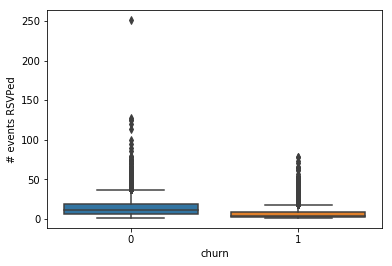

In [159]:
sns.boxplot(x='churn', y='# events RSVPed', data=df_users2)
plt.show()

# limit?

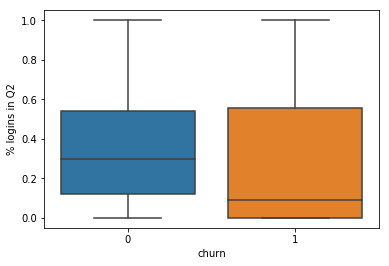

In [162]:
sns.boxplot(x='churn', y='% logins in Q2', data=df_users2)
plt.show()

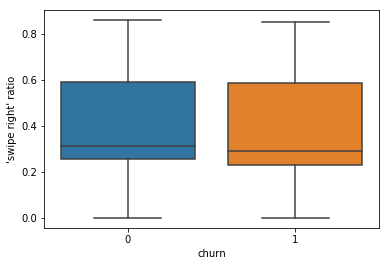

In [163]:
sns.boxplot(x='churn', y="'swipe right' ratio", data=df_users2)
plt.show()

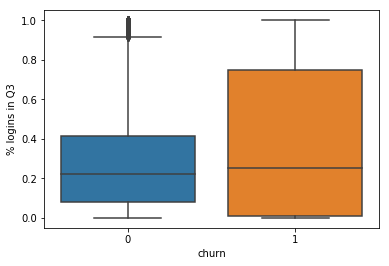

In [164]:
sns.boxplot(x='churn', y='% logins in Q3', data=df_users2)
plt.show()

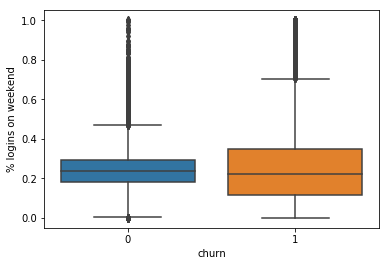

In [165]:
sns.boxplot(x='churn', y='% logins on weekend', data=df_users2)
plt.show()

In [150]:
def plot_importance(clf, X, max_features=10):
    '''Plot feature importance'''
    feature_importance = clf.feature_importances_
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + .5
    
    # Show only top features
    pos = pos[-max_features:]
    feature_importance = (feature_importance[sorted_idx])[-max_features:]
    feature_names = (X.columns[sorted_idx])[-max_features:]
    
    barlist = plt.barh(pos, feature_importance, align='center')
    for i, name in enumerate(feature_names):
        if name in churn_more_likely:
            barlist[i].set_color('r')
        else:
            barlist[i].set_color('g')
        
    plt.yticks(pos, feature_names)
    plt.xlabel('Feature Importance')
    plt.title('Top Features')
    plt.savefig('figure.png', bbox_inches='tight')

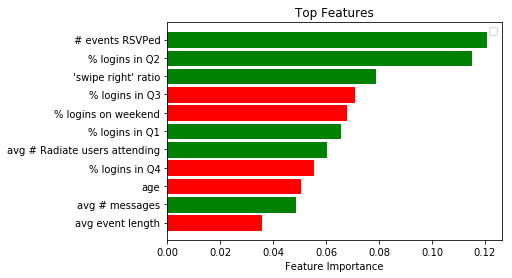

In [152]:
plot_importance(gbc_grid_cv, X, 11)

The green features above are associated with lower churn, and the red features are associated with higher churn.